# load images and labels as numpy arrays #

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import json
import skimage
import cv2

from ase.io import read
from ase.visualize.plot import plot_atoms

from mpl_toolkits.axes_grid1 import make_axes_locatable

/home/modules/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/site-packages/cryptography/hazmat/bindings/openssl/binding.py:173: CryptographyDeprecationWarning: OpenSSL version 1.0.2 is no longer supported by the OpenSSL project, please upgrade. The next version of cryptography will drop support for it.
  warnings.warn(


In [2]:
def expand_mask(mask, radius=10):
    expand = mask.copy()
    for j in range(radius,mask.shape[1]):
        for k in range(radius,mask.shape[2]):
            window = mask[0,j-radius:j+radius,k-radius:k+radius,0]
            fraction = np.count_nonzero(window == 1.0)/(window.shape[0]*window.shape[1])
            if fraction > 0.1:
                expand[0,j,k,0] = 1.0
    return expand

def trim_imagescale(img, percent=1):
    sorted_pixels = sorted(img.flatten())
    n = len(sorted_pixels)
    trim = int(n*percent/100)
    return sorted_pixels[trim: n-trim]

def fft(img):
    f = np.fft.fft2(img)
    f = np.fft.fftshift(f)
    cf = f.shape[0]/2,f.shape[1]/2
    f = f[int(cf[0]-80):int(cf[0]+80),int(cf[1]-80):int(cf[1]+80)]
    return np.log(1+np.abs(f))

In [7]:
image_no = 0
dataset1 = 'MoS2_tilt1_50keV'
model1 = read('../simulation_data/{}/model/model_{:04d}.cfg'.format(dataset1,image_no))
d = np.load('../simulation_data/{}/images_labels/image_label_000_{:04d}.npz'.format(dataset1, image_no))
with open('../simulation_data/{}/tem_params/parameters_000_{:04d}'.format(dataset1, image_no)) as json_file:
    params = json.load(json_file)
image = (d['image'])
label = (d['label'])

In [8]:
print("Image: ",image.dtype)
print(image.shape)
print("Label: ",label.dtype)
print(label.shape)

Image:  float32
(1, 400, 400, 3)
Label:  int8
(1, 400, 400, 4)


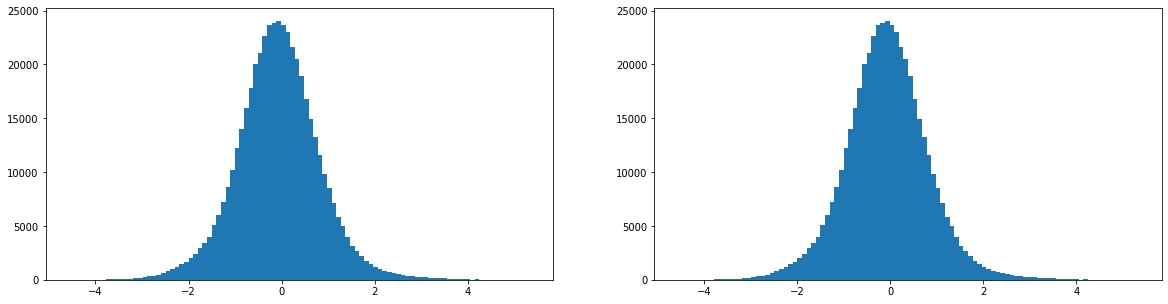

In [9]:
trimmed_pixels = trim_imagescale(image, percent=0)            # Trim away the upper and lower 1% (default)
scale = min(trimmed_pixels), max(trimmed_pixels)   # Save the values to scale

fig,ax=plt.subplots(figsize=(20.0,5.0),nrows=1,ncols=2)
ax[0].hist(image.flatten(),bins=100)
ax[1].hist(trimmed_pixels,bins=100)
plt.show()

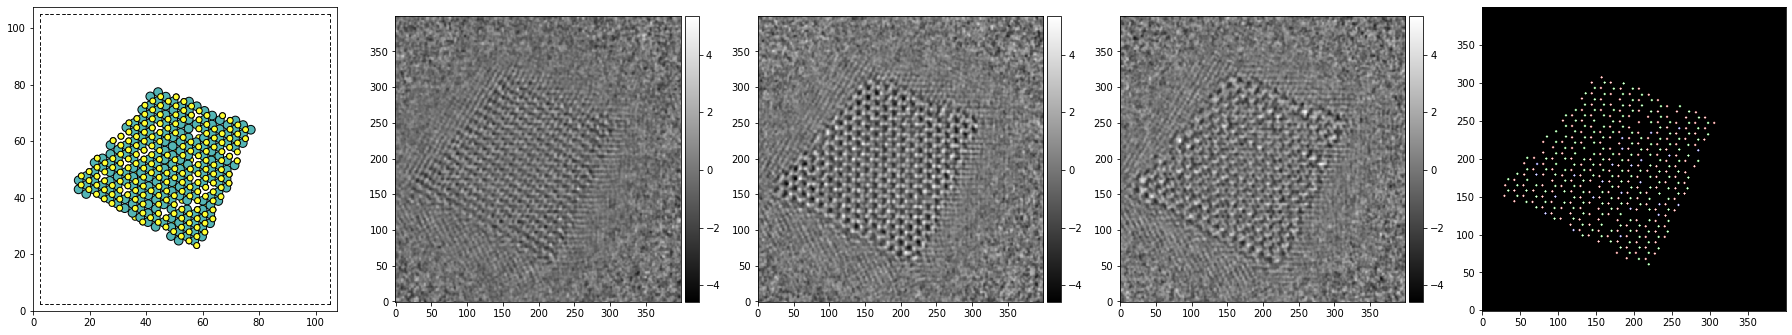

In [10]:
channels = image.shape[-1]
width = 25.0
fig = plt.figure(figsize=(width,width/(channels+1)))

ax = fig.add_subplot(1, channels+2, 1)
plot_atoms(model1,ax=ax)

for i in range(channels):
    ax = fig.add_subplot(1, channels+2, i+2)

    im = ax.imshow(image[0,:,:,i].T, origin='lower', interpolation='nearest', cmap='gray',vmin=scale[0],vmax=scale[1])
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax = cax1)

ax = fig.add_subplot(1, channels+2, channels+2)
im = ax.imshow(np.transpose(label[0,:,:,:].clip(0.0,1.0),(1,0,2)),origin='lower')

divider = make_axes_locatable(ax)
#cax2 = divider.append_axes("right", size="5%", pad=0.05)
#cbar = plt.colorbar(im, cax = cax2)
        
plt.tight_layout()
plt.show()

In [ ]:
blur_level=10

nanoparticle = label[0,:,:,0]
nanoparticle.shape = (1,) + nanoparticle.shape + (1,)

nanoparticle_crop = expand_mask(nanoparticle, radius=25)
#nanoparticle_crop = cv2.blur(nanoparticle_crop[0,:,:,0], (blur_level, blur_level))
#nanoparticle_crop = nanoparticle_crop.reshape((1,)+nanoparticle_crop.shape+(1,))

image_nanoparticle = image * nanoparticle_crop

substrate = label[0,:,:,1]
substrate.shape = (1,) + substrate.shape + (1,)

substrate_crop = expand_mask(substrate, radius=25)
#substrate_crop = cv2.blur(nsubstrate_crop[0,:,:,0], (blur_level, blur_level))
#substrate_crop = substrate_crop.reshape((1,)+substrate_crop.shape+(1,))

image_substrate = image * substrate_crop

NameError: name 'nanoparticle_crop' is not defined

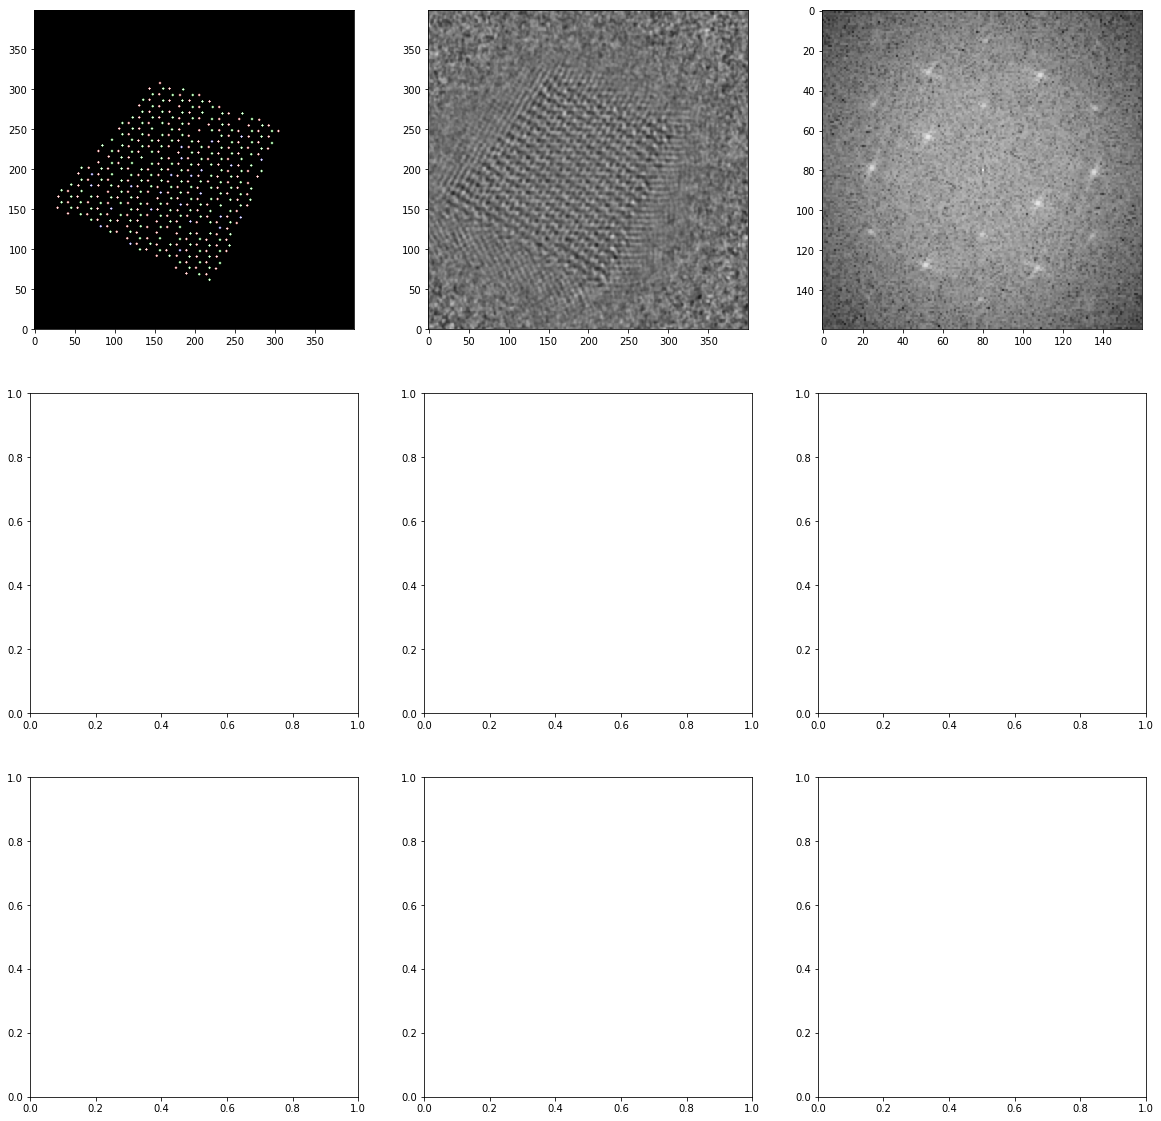

In [11]:
fig,ax=plt.subplots(figsize=(20.0,20.0),nrows=3,ncols=3)
ax[0,0].imshow(np.transpose(label[0,:,:,:].clip(0.0,1.0),(1,0,2)), origin='lower')
ax[0,1].imshow(image[0,:,:,0].T, origin='lower', interpolation='nearest', cmap='gray',vmin=scale[0],vmax=scale[1])
ax[0,2].imshow(fft(image[0,:,:,0]),cmap='gray')

ax[1,0].imshow(nanoparticle_crop[0,:,:,0].T, origin='lower', cmap='gray')
ax[1,1].imshow(image_nanoparticle[0,:,:,0].T, origin='lower', interpolation='nearest', cmap='gray',vmin=scale[0],vmax=scale[1])
ax[1,2].imshow(fft(image_nanoparticle[0,:,:,0]),cmap='gray')

ax[2,0].imshow(substrate_crop[0,:,:,0].T, origin='lower', cmap='gray')
ax[2,1].imshow(image_substrate[0,:,:,0].T, origin='lower', interpolation='nearest', cmap='gray',vmin=scale[0],vmax=scale[1])
ax[2,2].imshow(fft(image_substrate[0,:,:,0]),cmap='gray')

plt.show()